In [1]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

import json
import numpy as np
import matplotlib.pyplot as plt
import swiper.plot as plotter
from typing import Any

In [2]:
directory = 'slurm/data/20241108_171706'

In [3]:
with open(f'{directory}/config.json', 'r') as f:
    config = json.load(f)

In [4]:
data_by_config = {}

for file in os.listdir(f'{directory}/output/'):
    print(file)
    with open(f'{directory}/output/{file}', 'r') as f:
        contents = f.read()
        if len(contents) == 0:
            print('Empty file!')
            continue
        data = json.loads(contents)
    config_idx = int(file.split('_')[0][6:])
    data_by_config[config_idx] = data

config2_d21_aligned_separate_random_t_10000_200_0_0.json
config0_d21_sliding_separate_random_t_10000_200_0_0.json
config1_d21_parallel_separate_random_t_10000_200_0_0.json
config3_d21_parallel_None_random_t_10000_200_0_0.json
config4_d21_aligned_None_random_t_10000_200_0_0.json


In [5]:
def benchmark_name(conf):
    return conf['benchmark_file'].split('/')[-1].split('.')[0]

def get_config_idx(config, schedule_name, config_match):
    for idx, conf in enumerate(config):
        if benchmark_name(conf) == schedule_name and all(conf[k] == v for k, v in config_match.items()):
            return idx
    return None

def get_data(config, data_by_config, schedule_name, config_match):
    config_idx = get_config_idx(config, schedule_name, config_match)
    if config_idx is None:
        return None
    return data_by_config[config_idx]

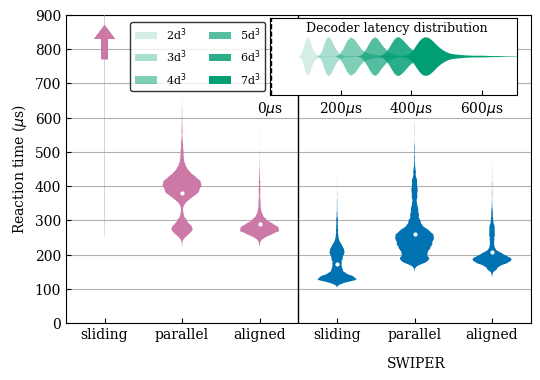

In [ ]:
ordered_configs = [
    ('sliding', False),
    ('parallel', False),
    ('aligned', False),
    ('sliding', True),
    ('parallel', True),
    ('aligned', True),
]
fig,ax = plt.subplots(figsize=(6,4))

colors = ['C1', 'C1', 'C1', 'C0', 'C0', 'C0']
for i,(scheduling_method,spec_on) in enumerate(ordered_configs):
    all_vals = []
    made_label = False
    for config_idx,data in data_by_config.items():
        spec = config[config_idx]['speculation_mode'] != None
        sched = config[config_idx]['scheduling_method']
        rng = config[config_idx]['rng']
        if sched != scheduling_method or spec != spec_on:
            continue
        parts = ax.violinplot(data['device_data']['conditioned_decode_wait_times'].values(), positions=[i], vert=True, widths=0.5, showextrema=False, points=1000, bw_method=0.05)
        for pc in parts['bodies']:
            pc.set_alpha(1)
            pc.set_facecolor(colors[i])
            pc.set_zorder(10)
        mean = np.mean(list(data['device_data']['conditioned_decode_wait_times'].values()))
        ax.plot([i], [mean], 'o', color='w', zorder=20, markersize=2)
    if i == 0:
        data = list(np.linspace(250, 1000, 100)) + [1000]*1000
        parts = ax.violinplot(data, positions=[i], vert=True, widths=0.5, showextrema=False)
        for pc in parts['bodies']:
            pc.set_alpha(1)
            pc.set_facecolor(colors[i])
            pc.set_zorder(10)
        ax.arrow(i, 780, dx=0, dy=60, head_width=0.1, head_length=15, fc=colors[i], ec=colors[i], linewidth=5, zorder=10)
        continue
ax.set_xticks(list(range(len(ordered_configs))), labels=[f'{scheduling_method}' for scheduling_method,spec_on in ordered_configs])#, rotation=45, ha='right')
ax.set_ylim(0, 900)
ax.set_ylabel(r'Reaction time ($\mu$s)')
ax.tick_params(direction='in')
ax.grid(axis='y', zorder=-10)
ax.set_xlim(-0.5, len(ordered_configs)-0.5)
ax.axvline(2.5, color='black', linewidth=1)
plt.figtext(0.66, 0, 'SWIPER')
# plt.show()

with open(f'benchmarks/data/decoder_dists.json', 'r') as f:
    decoder_dists = json.load(f)
ax_in = ax.inset_axes((0.44, 0.74, 0.53, 0.25))

# distances = [15, 17, 19, 21, 23, 25]
# highlight_dist = 21
volumes = [2,3,4,5,6,7]
for i,volume in enumerate(volumes):
    parts = ax_in.violinplot(np.array(decoder_dists['21'][str(volume)]), vert=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_alpha((volumes.index(volume)+1) / len(volumes))
        pc.set_facecolor(f'C2')
for i,volume in enumerate(volumes):
    ax_in.hist([-1], color='C2', label=f'{volume}'+r'd$^3$', alpha=(i+1) / len(volumes))
ax_in.axvline(1, color='black', linestyle='--', linewidth=1)
# ax_in.set_yscale('log')
ax_in.set_yticks([])
ax_in.tick_params(direction='in', which='both', right=True)
ax_in.set_xticks([0, 200, 400, 600], [r'0$\mu$s', r'200$\mu$s', r'400$\mu$s', r'600$\mu$s'])
ax_in.set_xlim(0,700)
ax_in.set_ylim(0.5,1.5)
# legend with black outline
ax_in.legend(loc='center right', bbox_to_anchor=(0, 0.5), ncol=2, fontsize=8, frameon=True, edgecolor='black')
ax_in.text(100, 1.32, 'Decoder latency distribution', fontsize=9)

# reverse entried in legend
handles, labels = ax_in.get_legend_handles_labels()
# for i in range(len(handles)):
    # if distances[i] == highlight_dist:
    #     handles[i].set_linewidth(3)
    # handles[i].set_alpha(1)
    # labels[i] = f'{distances[-i-1]}'
# legend off to right
# ax_in.legend(reversed(handles), reversed(labels), bbox_to_anchor=(1, 1), loc='upper right', ncol=1, fontsize=8, frameon=True)

plt.savefig('notebooks/figures/s_delay_inset.svg', bbox_inches='tight')
plt.savefig('notebooks/figures/s_delay_inset.pdf', bbox_inches='tight')
plt.show(fig)